## Example fits of different types

Plot time series from single process models with AR(n), ARIMA, ARFIMA fits.

Edits: 
- 28 Aug 2023: apply `hold_back` argument; plot AR(0) rather than AR(1) example
- Wed Dec 28 2022: plot catchment mean series rather than sum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from matplotlib import cm
import glob

In [2]:
model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
                'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']

In [50]:
## Read in time series
def read_catchment_series(fpath, anomaly=True):
    catchment_fpath = fpath
    catchment_tseries = pd.read_csv(catchment_fpath, index_col=0, parse_dates=[0])
    catchment_tseries.mask(catchment_tseries>1e30)
    anomaly_series = catchment_tseries - catchment_tseries.mean()
    if anomaly:
        return anomaly_series
    else:
        return catchment_tseries

def fit_catchment_series(tseries, which_model, comparison_n=range(0,6), hold_back=None,
                         seasonal=True):
    bic_per_n = pd.DataFrame(index=comparison_n, columns=model_names)
    
    if 'multi' in which_model:  ## allow multi-model mode reporting
        for m in model_names:
            for n in comparison_n:
                mod = AutoReg(tseries[m], n, trend='ct', seasonal=seasonal,
                             hold_back=hold_back)
                results = mod.fit()
                bic_per_n[m][n] = results.bic
            bic_per_n[m] = pd.to_numeric(bic_per_n[m])
        best_n = bic_per_n.idxmin().mode()[0]
    else:
        for n in comparison_n:
            mod = AutoReg(tseries[which_model], n, trend='ct', seasonal=seasonal,
                         hold_back=hold_back)
            results = mod.fit()
            bic_per_n[which_model][n] = results.bic
        bic_per_n[which_model] = pd.to_numeric(bic_per_n[which_model])
        best_n = bic_per_n[which_model].idxmin()
    
    bic_difference = bic_per_n.transform(lambda x: x-x.min())
    
    return best_n, bic_difference

def find_AR_residuals(tseries, which_model, chosen_n=1, 
                         seasonal=False, hold_back=None):
    mod = AutoReg(tseries[which_model], chosen_n, trend='ct', seasonal=seasonal,
                 hold_back=hold_back)
    results = mod.fit()
    resids = results.resid
    
    return resids

In [51]:
mod_fits = {m: [] for m in model_names}
mod_resids = {m: [] for m in model_names}
basin_i=101
ctmt_fpath = glob.glob('/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}_mean-tseries.csv'.format(basin_i))[0]
s = read_catchment_series(ctmt_fpath, anomaly=False)
a = s.resample('A').sum()
best_n, bic_diff = fit_catchment_series(a, which_model='multi', seasonal=False, hold_back=5)
#best_n = 1 ## force an AR(1) fit
for m in model_names:
    mod = AutoReg(a[m], best_n, trend='ct', seasonal=False, hold_back=5).fit()
    fv = mod.fittedvalues
    r = mod.resid
    mod_fits[m] = fv
    mod_resids[m] = r

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/447086503.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bic_per_n[m][n] = results.bic
/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/447086503.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bic_per_n[m][n] = results.bic
/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/447086503.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/1423671555.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))


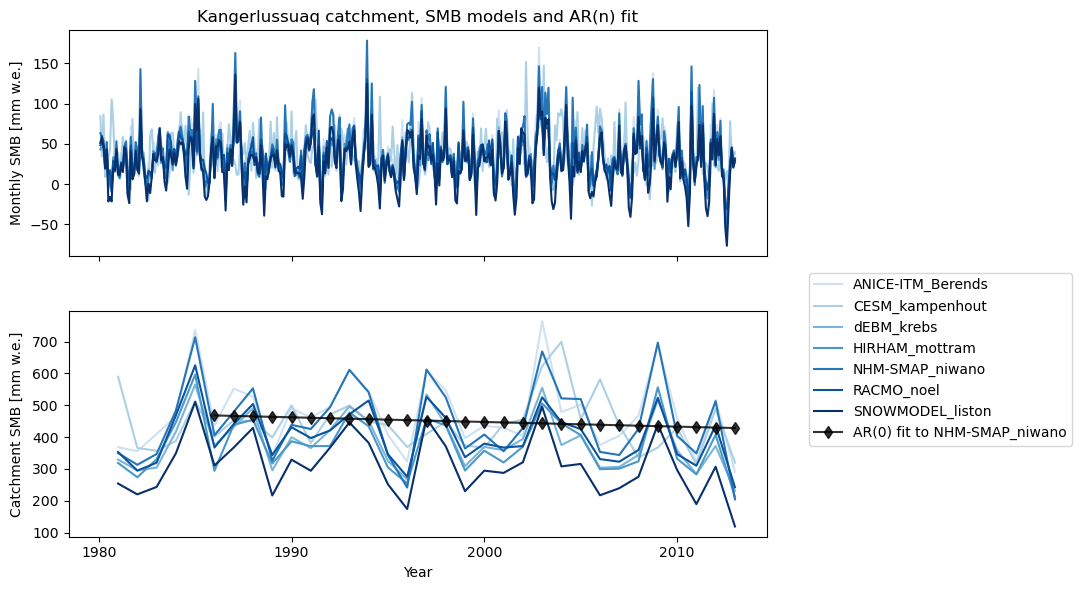

In [52]:
colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))

fig2, (ax4, ax5) = plt.subplots(2, figsize=(11,6), sharex=True)
for i,m in enumerate(model_names):
    ax4.plot(s[m], label=m, color=colors_w[i])
    ax5.plot(a[m], label=m, color=colors_w[i]) 
## highlight AR fit to just one model
example_model = model_names[4]
ax5.plot(mod_fits[example_model], color='k', alpha=0.8, marker='d', 
         label='AR({}) fit to {}'.format(best_n, example_model))

ax4.set(ylabel='Monthly SMB [mm w.e.]', 
        title='Kangerlussuaq catchment, SMB models and AR(n) fit')
#ax5.set(ylabel='Annual SMB [mm w.e.]')
ax5.set(xlabel='Year', ylabel='Catchment SMB [mm w.e.]',
        # title='Basin {}, all models'.format(basin_i)
        # title='Kangerlussuaq catchment, SMB model and AR(n) fit',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010)
        )
#ax4.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left') ## shared legend
fig2.align_ylabels((ax4, ax5))
plt.tight_layout()
plt.show()
# plt.savefig('/Users/lizz/Desktop/20210622-kanger_tseries-large_ex.png', dpi=300)

Now plot fit with different model types.

In [70]:
example_model = model_names[3]
example_series = a[example_model]

## ARIMA fit
lag_acf = sm.tsa.stattools.acf(example_series, nlags=10)
lag_pacf = sm.tsa.stattools.pacf(example_series, nlags=10, method='ols')
upper_confidence = 1.96/np.sqrt(len(example_series))
p_candidates = np.argwhere(lag_pacf > upper_confidence).squeeze()
try:
    p = p_candidates[p_candidates >0][0] # choose first nonzero value that exceeds upper CI
except IndexError: ## catch if there are no suitable candidates and give a default value to test
    p = 1
q_candidates = np.argwhere(lag_acf > upper_confidence).squeeze()
try:
    q = p_candidates[p_candidates >0][0] 
except IndexError: 
    q = 1
d = 0 # no differencing in ARIMA; apply only the differencing above in fracdiff
print('Order of ARIMA model: ({},{},{})'.format(p,d,q))

mod_arima = sm.tsa.arima.ARIMA(example_series, order=(p,d,q),
                               dates=pd.to_datetime(example_series.index))

results_arima = mod_arima.fit()
print('Bayesian Information Criterion for {}, ARIMA({}, {}, {}): {}'.format(
    example_model, p,d,q, results_arima.bic))

Order of ARIMA model: (1,0,1)
Bayesian Information Criterion for HIRHAM_mottram, ARIMA(1, 0, 1): 398.68166080841877


/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/3846846313.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))


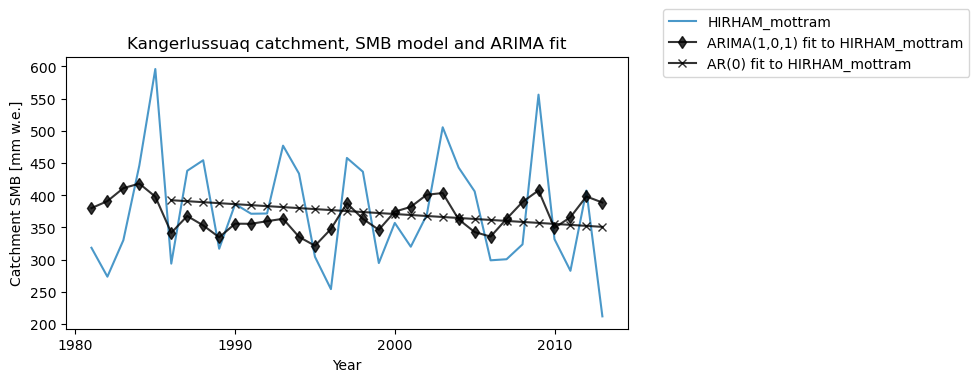

In [71]:
## Plot a single timeseries with ARIMA fit
colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))
fig, ax = plt.subplots(figsize=(10,4))
for i,m in enumerate(model_names):
    if m==example_model:
        ax.plot(a[m], label=m, color=colors_w[i])
        ax.plot(results_arima.predict(), color='k', alpha=0.8, marker='d', 
                  label='ARIMA({},{},{}) fit to {}'.format(p,d,q, m))
        ax.plot(mod_fits[m], color='k', alpha=0.8, marker='x', 
                  label='AR({}) fit to {}'.format(best_n, m))
    else:
        pass
ax.set(xlabel='Year', ylabel='Catchment SMB [mm w.e.]',
        # title='Basin {}, all models'.format(basin_i)
        title='Kangerlussuaq catchment, SMB model and ARIMA fit',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010)
        )
ax.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
plt.show()

In [72]:
mod_AR = AutoReg(example_series, best_n, trend='ct', seasonal=False, hold_back=5)
results_AR = mod_AR.fit()

In [73]:
results_AR.bic

334.51469686052076

In [74]:
other_example_order = 5
mod_AR_ex = AutoReg(example_series, other_example_order, trend='ct', seasonal=False, hold_back=5)
results_AR_ex = mod_AR_ex.fit()

In [75]:
### KUTTRUF FUNCTIONS

def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

In [76]:
example_fd_order = 0.5
example_fracdiff = ts_differencing(example_series, order=example_fd_order, lag_cutoff=5)

## Now fit an ARIMA model to already fractionally differenced series
lag_acf = sm.tsa.stattools.acf(example_fracdiff, nlags=10)
lag_pacf = sm.tsa.stattools.pacf(example_fracdiff, nlags=10, method='ols')
upper_confidence = 1.96/np.sqrt(len(example_fracdiff))
p_candidates = np.argwhere(lag_pacf > upper_confidence).squeeze()
p_arfima = p_candidates[p_candidates >=0][0] # choose first nonzero value that exceeds upper CI
q_candidates = np.argwhere(lag_acf > upper_confidence).squeeze()
q_arfima = p_candidates[p_candidates >=0][0] 
d_arfima = 0 # no differencing in ARIMA; apply only the differencing above in fracdiff
print('Order of ARFIMA model: ({},{},{})'.format(p_arfima,example_fd_order,q_arfima))

mod_arfima = sm.tsa.arima.ARIMA(example_fracdiff, order=(p_arfima,d_arfima,q_arfima), 
                                dates=pd.to_datetime(example_fracdiff.index))
results_arfima = mod_arfima.fit()


Order of ARFIMA model: (0,0.5,0)


In [77]:
results_arfima.bic

342.55339733019116

In [78]:
example_reconstruct = ts_differencing(results_arfima.predict(), order=-1*example_fd_order, lag_cutoff=5) + results_arfima.predict()[0]
## negative difference and add first element? https://stats.stackexchange.com/questions/404475/fractional-un-differencing-of-time-series

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1890/2381822000.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))


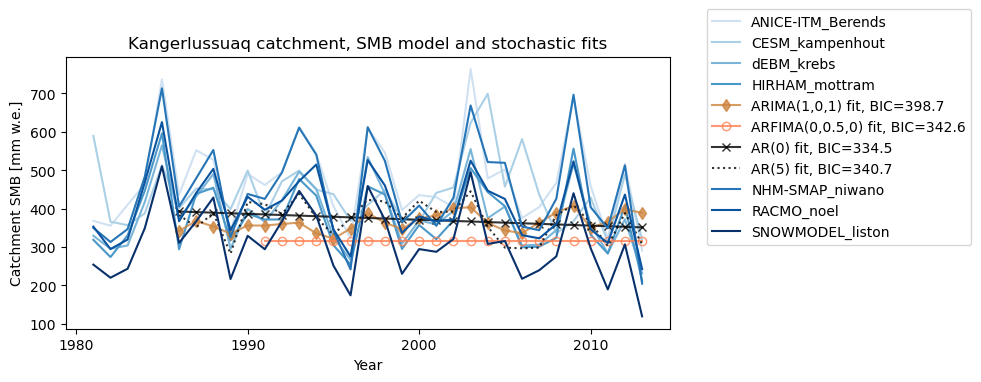

In [79]:
colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(model_names)))
fig, ax = plt.subplots(figsize=(10,4))
for i,m in enumerate(model_names):
    if m!=example_model:
        ax.plot(a[m], label=m, color=colors_w[i])
    else:
        ax.plot(a[m], label=m, color=colors_w[i])
        ax.plot(results_arima.predict()[5::], color='peru', alpha=0.8, marker='d', 
                  label='ARIMA({},{},{}) fit, BIC={:.1f}'.format(p,d,q, results_arima.bic))
        ax.plot(results_arfima.predict().index[5::], example_reconstruct, 
                color='coral', alpha=0.8, marker='o', fillstyle='none',
                  label='ARFIMA({},{},{}) fit, BIC={:.1f}'.format(p_arfima,example_fd_order,q_arfima, results_arfima.bic))
        ax.plot(results_AR.predict(), color='k', alpha=0.8, marker='x', 
                  label='AR({}) fit, BIC={:.1f}'.format(best_n, results_AR.bic))
        ax.plot(results_AR_ex.predict(), color='k', alpha=0.8, ls=':', 
                  label='AR({}) fit, BIC={:.1f}'.format(other_example_order, results_AR_ex.bic))
#         ax.plot(results_arfima.predict(), color='coral', alpha=0.8, marker='o', 
#                   label='ARFIMA fit, BIC={:.1f}'.format(results_arfima.bic))
        # attempt reconstruction by un-differencing?


ax.set(xlabel='Year', ylabel='Catchment SMB [mm w.e.]',
        # title='Basin {}, all models'.format(basin_i)
        title='Kangerlussuaq catchment, SMB model and stochastic fits',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010)
        )
ax.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
plt.show()

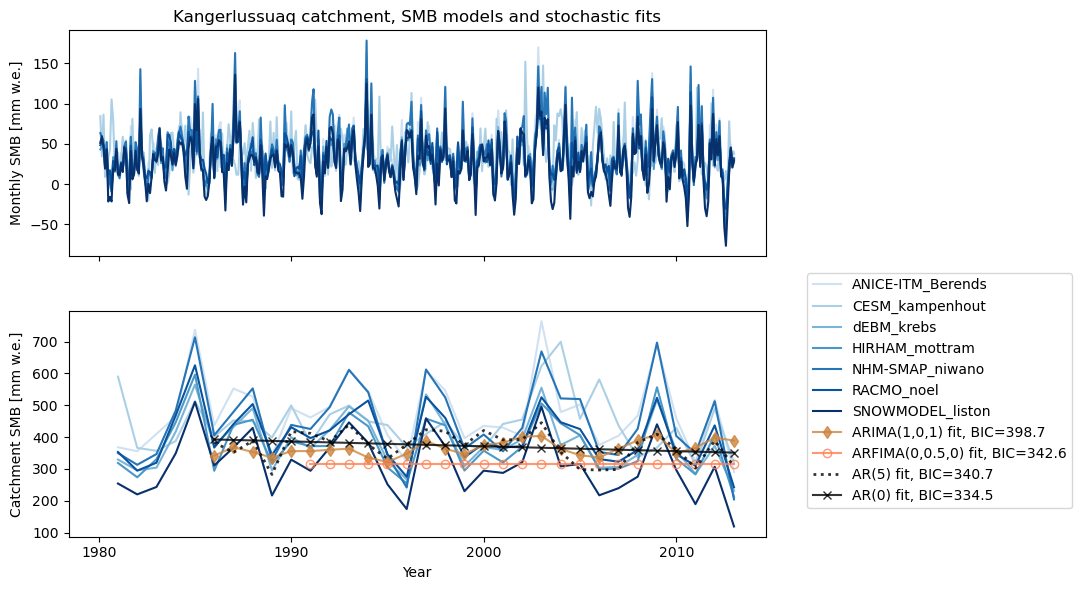

In [80]:
## Make two-panel version to show as Figure 3 in manuscript

fig2, (ax4, ax5) = plt.subplots(2, figsize=(11,6), sharex=True)
for i,m in enumerate(model_names):
    ax4.plot(s[m], label=m, color=colors_w[i])
    ax5.plot(a[m], label=m, color=colors_w[i]) 
## highlight AR fit to just one model
example_model = model_names[4]
ax5.plot(results_arima.predict()[5::], color='peru', alpha=0.8, marker='d', 
          label='ARIMA({},{},{}) fit, BIC={:.1f}'.format(p,d,q, results_arima.bic))
ax5.plot(results_arfima.predict().index[5::], example_reconstruct, 
        color='coral', alpha=0.8, marker='o', fillstyle='none',
          label='ARFIMA({},{},{}) fit, BIC={:.1f}'.format(p_arfima,example_fd_order,q_arfima, results_arfima.bic))
ax5.plot(results_AR_ex.predict(), color='k', alpha=0.8, ls=':', lw=2.0,
         label='AR({}) fit, BIC={:.1f}'.format(other_example_order, results_AR_ex.bic))
ax5.plot(results_AR.predict(), color='k', alpha=0.8, marker='x', 
          label='AR({}) fit, BIC={:.1f}'.format(best_n, results_AR.bic))

ax4.set(ylabel='Monthly SMB [mm w.e.]', 
        title='Kangerlussuaq catchment, SMB models and stochastic fits')
#ax5.set(ylabel='Annual SMB [mm w.e.]')
ax5.set(xlabel='Year', ylabel='Catchment SMB [mm w.e.]',
        # title='Basin {}, all models'.format(basin_i)
        # title='Kangerlussuaq catchment, SMB model and AR(n) fit',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010)
        )
#ax4.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left') ## shared legend
fig2.align_ylabels((ax4, ax5))
plt.tight_layout()
plt.show()